In [1]:
import requests
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import numpy as np
import os
#from dotenv import load_dotenv
import sqlite3
#from google.cloud import secretmanager
#from google.auth import default
#from google.cloud import bigquery
from datetime import datetime

In [2]:
# Set to "true" if running manually from csv (e.g. for saving API credits). Else set to false
from_csv = True

In [2]:
# Access the API key

def access_secret(secret_id, project_id):
    """
    Retrieve a secret from Google Cloud Secret Manager.
    
    Args:
        secret_id (str): The ID of the secret to retrieve
        project_id (str): Your Google Cloud project ID
    
    Returns:
        str: The secret value
    """
    
    credentials, project_id = default()
    client = secretmanager.SecretManagerServiceClient(credentials=credentials)

    try:
        # Explicitly get credentials
        name = f"projects/{project_id}/secrets/{secret_id}/versions/latest"
        # Access the secret version
        response = client.access_secret_version(request={"name": name})
        
        # Return the decoded secret
        return response.payload.data.decode('UTF-8')
    
    except Exception as e:
        print(f"Error accessing secret: {e}")
        return None

api_key = access_secret(secret_id="ALPHAVANTAGE_API_KEY",project_id="562376856357")

In [3]:
tickers_dict = {
    'YPF Sociedad Anonima' : 'YPF',
    'Grupo Supervielle' : 'SUPV',
    'Grupo Financiero Galicia ADR' : 'GGAL',
    'BBVA Argentina' : 'BBAR',
    'Banco Macro B ADR' : 'BMA',
    'Telecom Argentina ADR' : 'TEO',
    'Cresud SACIF' : 'CRESY',
    'Central Puerto' : 'CEPU',
    'Pampa Energia ADR' : 'PAM',
    'Loma Negra ADR' : 'LOMA',
    'IRSA ADR' : 'IRS',
    'Transportadora Gas ADR' : 'TGS',
    'Bioceres Crop' : 'BIOX',
    'Edenor ADR' : 'EDN'
}


In [4]:
tickers_list = list(tickers_dict.values())

In [5]:
cap_bursatiles_25_feb_25 = {
    'YPF Sociedad Anonima' :            13946871640,
    'Grupo Supervielle' :               1233150264,
    'Grupo Financiero Galicia ADR' :    8523720280,
    'BBVA Argentina' :                  3843734562,
    'Banco Macro B ADR' :               5493200605,
    'Telecom Argentina ADR' :           5272228248,
    'Cresud SACIF' :                    633031172,
    'Central Puerto' :                  1881929669,
    'Pampa Energia ADR' :               4208906073,
    'Loma Negra ADR' :                  1295332593,
    'IRSA ADR' :                        1042296329,
    'Transportadora Gas ADR' :          3894785724,
    'Bioceres Crop' :                   276407628,
    'Edenor ADR' :                      1623461084
}

cap_bursatiles_16_jul_25 = {
    'YPF Sociedad Anonima' :            12102234641,         
    'Grupo Supervielle' :               889238357,                  
    'Grupo Financiero Galicia ADR' :    7465867337,                 
    'BBVA Argentina' :                  3005342937,                    
    'Banco Macro B ADR' :               4078498436,                    
    'Telecom Argentina ADR' :           3848640474,                    
    'Cresud SACIF' :                    644063746,                    
    'Central Puerto' :                  1712056372,                    
    'Pampa Energia ADR' :               3840171311,                    
    'Loma Negra ADR' :                  1220646750,                    
    'IRSA ADR' :                        1086066840,                    
    'Transportadora Gas ADR' :          3863169760,                    
    'Bioceres Crop' :                   240709690,                   
    'Edenor ADR' :                      1112447021                    
}

# Seleccionar el diccionario más reciente de 
# capitalizaciones bursátiles
cap_bursatiles = cap_bursatiles_16_jul_25

suma_cap = sum(cap_bursatiles.values())

firmas_y_pond = []

for i in cap_bursatiles:
    firmas_y_pond.append([i, (cap_bursatiles[i]/suma_cap)])

ponderadores = dict(firmas_y_pond)

In [6]:
12102234641/suma_cap

0.26828777877320403

In [7]:
tickers_y_ponderadores = {tickers_dict[nombre_empresa]:ponderador for (nombre_empresa,ponderador) in ponderadores.items()}

In [8]:
tickers_y_ponderadores

{'YPF': 0.26828777877320403,
 'SUPV': 0.019713035705920704,
 'GGAL': 0.16550670383413085,
 'BBAR': 0.0666237934511608,
 'BMA': 0.09041398705140398,
 'TEO': 0.08531839240399926,
 'CRESY': 0.014277894697008716,
 'CEPU': 0.03795363540732315,
 'PAM': 0.08513064419081881,
 'LOMA': 0.02705984596553572,
 'IRS': 0.024076418012562707,
 'TGS': 0.08564048414851848,
 'BIOX': 0.0053361606327234756,
 'EDN': 0.024661225725689337}

In [9]:
firmas_y_pond

[['YPF Sociedad Anonima', 0.26828777877320403],
 ['Grupo Supervielle', 0.019713035705920704],
 ['Grupo Financiero Galicia ADR', 0.16550670383413085],
 ['BBVA Argentina', 0.0666237934511608],
 ['Banco Macro B ADR', 0.09041398705140398],
 ['Telecom Argentina ADR', 0.08531839240399926],
 ['Cresud SACIF', 0.014277894697008716],
 ['Central Puerto', 0.03795363540732315],
 ['Pampa Energia ADR', 0.08513064419081881],
 ['Loma Negra ADR', 0.02705984596553572],
 ['IRSA ADR', 0.024076418012562707],
 ['Transportadora Gas ADR', 0.08564048414851848],
 ['Bioceres Crop', 0.0053361606327234756],
 ['Edenor ADR', 0.024661225725689337]]

In [10]:
sum(tickers_y_ponderadores.values())

1.0

In [ ]:
# Este script "hereda" el ajuste de encadenamiento
# a fecha febrero de 2025 del script 'ArgDR_index_v1.0.ipynb'
chain_adjustment_feb_25 = 0.911886396417253

**Reponderación del 2025-07-16**: 

$$CA_{jul25} = CA_{feb25} \cdot \frac{ArgDR^{jul25}_{pond\_feb25}}{ArgDR^{jul25}_{pond\_jul25}}$$
Donde $CA_{t}$ es el chain_adjustment del mes $t$ y $ArgDR^{jul25}_{pond\_t}$ es el índice para el 16 de julio de 2025 con los ponderadores del mes $t$

$$CA_{jul25} = 0.911886396417253 \cdot \frac{30.557460258024143}{30.66225019226724}$$

In [25]:
# En base a lo explicado en la celda de arriba:
chain_adjustment_jul_25 = 0.911886396417253 * 30.557460258024143 / 30.66225019226724
chain_adjustment_jul_25

0.9087699742721543

In [9]:
def get_data_from_api(ticker:str, function='TIME_SERIES_INTRADAY'):
    base_url = "https://www.alphavantage.co/query"
    params = {
        "function": function,
        "symbol": ticker,
        "interval": "60min",
        "apikey": api_key,
        "extended_hours": "false"
    }
    response = requests.get(base_url, params=params)
    
    # Check if the request was successful
    if response.status_code == 200:
        return response.json()
    else:
        return f"Error: {response.status_code}, {response.text}"

In [10]:
def get_date_and_latest_price(ticker:str):
    api_data = get_data_from_api(ticker)
    date_and_price = list(api_data['Time Series (60min)'].items())[0]
    date = date_and_price[0]
    closing_price = date_and_price[1]['4. close']
    return date, closing_price

In [ ]:
if from_csv == False:
    dates = []
    df_rows = []
    for ticker in tickers_list:
        date, closing_price = get_date_and_latest_price(ticker)
        dates.append(date)
        ticker_and_price = {'Ticker':ticker,'Precio de cierre':closing_price,'Ponderador':tickers_y_ponderadores[ticker]}
        df_rows.append(ticker_and_price)

In [12]:
def generate_table_from_csv(csvfile):
    
    import pandas as pd

    tablaADR = pd.read_csv(csvfile)

    tablaADR = pd.DataFrame(tablaADR)

    tablaADR.set_index('Name', inplace = True)

    #print(tablaADR.index.values)

    # Removemos MELI y DESP de la tabla

    tablaADR_sinMELI = tablaADR.drop(['MercadoLibre'])

    #print(tablaADR_sinMELI.index.values)

    tablaADR_sinMELI = tablaADR_sinMELI.sort_values(by ='Name')

    
    

    return tablaADR_sinMELI

In [13]:
if from_csv == True:
    tablaADR_csv = generate_table_from_csv('csv_data\Argentina_ADRs.csv')

<>:2: SyntaxWarning: invalid escape sequence '\A'
<>:2: SyntaxWarning: invalid escape sequence '\A'
C:\Users\andre\AppData\Local\Temp\ipykernel_7840\2927449826.py:2: SyntaxWarning: invalid escape sequence '\A'
  tablaADR_csv = generate_table_from_csv('csv_data\Argentina_ADRs.csv')


In [14]:
tablaADR_csv

,Last,High,Low,Chg.,Chg. %,Vol.,Time
Name,,,,,,,
BBVA Argentina,14.840,15.270,14.610,-0.260,-1.72%,998.61K,15:59:59
Banco Macro B ADR,63.14,66.41,62.51,-3.110,-4.69%,661.59K,15:59:59
Bioceres Crop,3.81,3.91,3.79,-0.080,-2.06%,41.37K,15:59:59
Central Puerto,11.280,11.440,11.160,-0.070,-0.62%,135.51K,15:59:59
Cresud SACIF,10.880,10.940,10.670,0.070,0.65%,132.54K,15:59:59
Edenor ADR,24.590,25.410,24.250,-0.630,-2.50%,133.59K,15:59:59
Grupo Financiero Galicia ADR,46.380,47.800,46.020,-1.080,-2.28%,1.45M,15:59:59
Grupo Supervielle,9.635,10.165,9.480,-0.465,-4.60%,1.6M,15:59:59
IRSA ADR,14.530,14.680,14.300,-0.020,-0.14%,163.64K,15:59:59


In [15]:
def preciosypond(df_from_csv):
    ponderadores_df = pd.DataFrame(ponderadores.values(), index=ponderadores.keys())
    ponderadores_df = ponderadores_df.sort_index()
    #print(ponderadores_df)
    datos_df = df_from_csv
    precios_y_pond = ponderadores_df.merge(datos_df, left_on=ponderadores_df.index, right_on = 'Name')
    precios_y_pond.rename(columns = {0 : 'Ponderador'}, inplace=True)
    return precios_y_pond

In [16]:
preciosypond(tablaADR_csv)

,Name,Ponderador,Last,High,Low,Chg.,Chg. %,Vol.,Time
0,BBVA Argentina,0.066624,14.840,15.270,14.610,-0.260,-1.72%,998.61K,15:59:59
1,Banco Macro B ADR,0.090414,63.14,66.41,62.51,-3.110,-4.69%,661.59K,15:59:59
2,Bioceres Crop,0.005336,3.81,3.91,3.79,-0.080,-2.06%,41.37K,15:59:59
3,Central Puerto,0.037954,11.280,11.440,11.160,-0.070,-0.62%,135.51K,15:59:59
4,Cresud SACIF,0.014278,10.880,10.940,10.670,0.070,0.65%,132.54K,15:59:59
5,Edenor ADR,0.024661,24.590,25.410,24.250,-0.630,-2.50%,133.59K,15:59:59
6,Grupo Financiero Galicia ADR,0.165507,46.380,47.800,46.020,-1.080,-2.28%,1.45M,15:59:59
7,Grupo Supervielle,0.019713,9.635,10.165,9.480,-0.465,-4.60%,1.6M,15:59:59
8,IRSA ADR,0.024076,14.530,14.680,14.300,-0.020,-0.14%,163.64K,15:59:59
9,Loma Negra ADR,0.027060,10.410,10.795,10.370,-0.280,-2.62%,197.35K,15:59:59


In [17]:
if from_csv == False:
    df = pd.DataFrame(df_rows)
elif from_csv == True:
    df = preciosypond(tablaADR_csv)

In [18]:
df

,Name,Ponderador,Last,High,Low,Chg.,Chg. %,Vol.,Time
0,BBVA Argentina,0.066624,14.840,15.270,14.610,-0.260,-1.72%,998.61K,15:59:59
1,Banco Macro B ADR,0.090414,63.14,66.41,62.51,-3.110,-4.69%,661.59K,15:59:59
2,Bioceres Crop,0.005336,3.81,3.91,3.79,-0.080,-2.06%,41.37K,15:59:59
3,Central Puerto,0.037954,11.280,11.440,11.160,-0.070,-0.62%,135.51K,15:59:59
4,Cresud SACIF,0.014278,10.880,10.940,10.670,0.070,0.65%,132.54K,15:59:59
5,Edenor ADR,0.024661,24.590,25.410,24.250,-0.630,-2.50%,133.59K,15:59:59
6,Grupo Financiero Galicia ADR,0.165507,46.380,47.800,46.020,-1.080,-2.28%,1.45M,15:59:59
7,Grupo Supervielle,0.019713,9.635,10.165,9.480,-0.465,-4.60%,1.6M,15:59:59
8,IRSA ADR,0.024076,14.530,14.680,14.300,-0.020,-0.14%,163.64K,15:59:59
9,Loma Negra ADR,0.027060,10.410,10.795,10.370,-0.280,-2.62%,197.35K,15:59:59


In [19]:
sum(df['Ponderador'])

1.0

In [20]:
def calculo_indice(df:pd.DataFrame, chain_adjustment):
    if from_csv == False:
        vector_pond = pd.Series(df['Ponderador'])
        vector_ult_precio = pd.Series(df['Precio de cierre'], dtype='float')
        ArgDR_Index = vector_pond.dot(vector_ult_precio) * chain_adjustment
        return ArgDR_Index
    elif from_csv == True:
        vector_pond = pd.Series(df['Ponderador'])
        vector_ult_precio = pd.Series(df['Last'], dtype='float')
        ArgDR_Index = vector_pond.dot(vector_ult_precio) * chain_adjustment
        return ArgDR_Index

In [21]:
valor = calculo_indice(df,chain_adjustment_feb_25)

In [22]:
if from_csv == False:
    print(valor)

In [23]:
fecha = dates[-1]

NameError: name 'dates' is not defined

In [24]:
if from_csv == False:
    print((fecha,valor))
elif from_csv == True:
    print((valor))

30.66225019226724


In [18]:

def add_to_bigquery(fecha, valor, project_id="abiding-lead-452321-n0", dataset_id="adr_index", table_id="argdr_serie_historica"):
    """
    Adds a (fecha, valor) tuple as a new row to a BigQuery table.
    
    Parameters:
    fecha (str or datetime): The date value to insert, can be a string like '2024-02-26 13:49:00'
    valor (float): The value to insert
    project_id (str): The GCP project ID
    dataset_id (str): The BigQuery dataset ID
    table_id (str): The BigQuery table ID
    
    Returns:
    bool: True if the operation was successful, False otherwise
    """
    # Initialize a BigQuery client
    client = bigquery.Client()
    
    # Construct the full table ID
    table_ref = f"{project_id}.{dataset_id}.{table_id}"
        
    # Ensure valor is a float
    try:
        valor = float(valor)
    except (ValueError, TypeError):
        print(f"Error: 'valor' must be a numeric value, got {valor}")
        return False
    
    # Prepare the row to be inserted
    row_to_insert = [
        {"Fecha": fecha, 
         "Valor": valor}
    ]
    
    # Configure the load job
    job_config = bigquery.LoadJobConfig(
        # Specify the write disposition to append data
        write_disposition=bigquery.WriteDisposition.WRITE_APPEND,
        # Auto-detect the schema
        autodetect=True,
    )
    
    try:
        # Insert the row into the table
        load_job = client.load_table_from_json(
            row_to_insert, 
            table_ref, 
            job_config=job_config
        )
        
        # Wait for the job to complete
        load_job.result()
        
        print(f"Successfully added data to {table_ref}")
        return True
        
    except Exception as e:
        print(f"Error adding data to BigQuery: {e}")
        return False

# Example usage:
# String date example
# fecha_string = "2024-02-26 13:49:00"
# valor_ejemplo = 123.45
# add_to_bigquery(fecha_string, valor_ejemplo)

In [19]:
add_to_bigquery(fecha,valor)

Successfully added data to abiding-lead-452321-n0.adr_index.argdr_serie_historica


True

In [ ]:
from google.cloud import bigquery

def get_bigquery_data(project_id="abiding-lead-452321-n0", dataset_id="adr_index", table_id="argdr_serie_historica"):
    """
    Returns all data from a BigQuery table as a pandas DataFrame.
    
    Parameters:
    project_id (str): The GCP project ID
    dataset_id (str): The BigQuery dataset ID
    table_id (str): The BigQuery table ID
    
    Returns:
    pandas.DataFrame: DataFrame containing all data from the specified BigQuery table
    """
    # Initialize a BigQuery client
    client = bigquery.Client()
    
    # Construct the full table ID
    table_ref = f"{project_id}.{dataset_id}.{table_id}"
    
    try:
        # Construct a SQL query to get all data from the table
        query = f"SELECT * FROM `{table_ref}`"
        
        # Execute the query and convert results to a DataFrame
        print(f"Fetching data from {table_ref}...")
        df = client.query(query).to_dataframe()
        df = df.sort_values(by='Fecha')
        df = df.reset_index(drop=True)
        
        # Print information about the resulting DataFrame
        print(f"Successfully loaded {len(df)} rows into DataFrame")
        print(f"DataFrame columns: {df.columns.tolist()}")
        print(f"DataFrame data types: \n{df.dtypes}")
        
        return df
        
    except Exception as e:
        print(f"Error fetching data from BigQuery: {e}")
        return None

# Example usage:
# df = get_bigquery_data()
# print(df.head())  # Display the first 5 rows


In [2]:
result = get_bigquery_data()
result

Fetching data from abiding-lead-452321-n0.adr_index.argdr_serie_historica...


c:\Users\andre\py_valiant\Lib\site-packages\google\cloud\bigquery\table.py:1900: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


Successfully loaded 262 rows into DataFrame
DataFrame columns: ['Fecha', 'Valor']
DataFrame data types: 
Fecha    datetime64[us, UTC]
Valor                float64
dtype: object


,Fecha,Valor
0,2023-07-03 23:59:00+00:00,15.790400
1,2024-01-02 23:59:00+00:00,17.202437
2,2024-02-01 23:59:00+00:00,17.984130
3,2024-02-21 18:58:00+00:00,17.569293
4,2024-02-23 20:15:00+00:00,18.555700
...,...,...
257,2025-03-05 15:00:00+00:00,36.751383
258,2025-03-06 15:00:00+00:00,35.821738
259,2025-03-07 15:00:00+00:00,36.439196
260,2025-03-10 15:00:00+00:00,34.246644


In [8]:
def filter_dataframe_by_date(df, start_date):
    """
    Filter a DataFrame by date, handling timezone issues.
    
    Parameters:
    df (pandas.DataFrame): DataFrame with datetime index
    start_date (str): Date string in format 'YYYY-MM-DD'
    
    Returns:
    pandas.DataFrame: Filtered DataFrame
    """
    # Check if the DataFrame index has timezone info
    is_tz_aware = df.index.tz is not None
    
    # Convert start_date to datetime with appropriate timezone
    if is_tz_aware:
        print('tz_aware')
        # If DataFrame has timezone, make sure start_date has the same timezone
        tz = df.index.tz
        start_datetime = pd.to_datetime(start_date).tz_localize(tz)
    else:
        # If DataFrame has no timezone, use naive datetime
        start_datetime = pd.to_datetime(start_date)
    
    # Filter the DataFrame
    filtered_df = df[df.index >= start_datetime]
    print(f"Filtered from {len(df)} to {len(filtered_df)} rows")
    
    return filtered_df


In [11]:
result

,Valor
Fecha,
2023-07-03 23:59:00+00:00,15.790400
2024-01-02 23:59:00+00:00,17.202437
2024-02-01 23:59:00+00:00,17.984130
2024-02-21 18:58:00+00:00,17.569293
2024-02-23 20:15:00+00:00,18.555700
...,...
2025-03-05 15:00:00+00:00,36.751383
2025-03-06 15:00:00+00:00,35.821738
2025-03-07 15:00:00+00:00,36.439196


In [16]:
# Create a DataFrame with proper datetime index
#df = pd.DataFrame({'values': result['Valor']}, index=result['Fecha'])
#result = result.set_index('Fecha')
result.index = pd.to_datetime(result.index)
filtered_df = filter_dataframe_by_date(result, start_date='2024-07-01')
filtered_df

tz_aware
Filtered from 262 to 162 rows


,Valor
Fecha,
2024-07-01 13:58:00+00:00,21.205798
2024-07-01 18:17:00+00:00,20.840702
2024-07-02 17:36:00+00:00,21.319643
2024-07-03 22:16:00+00:00,21.642046
2024-07-05 14:05:00+00:00,21.546219
...,...
2025-03-05 15:00:00+00:00,36.751383
2025-03-06 15:00:00+00:00,35.821738
2025-03-07 15:00:00+00:00,36.439196


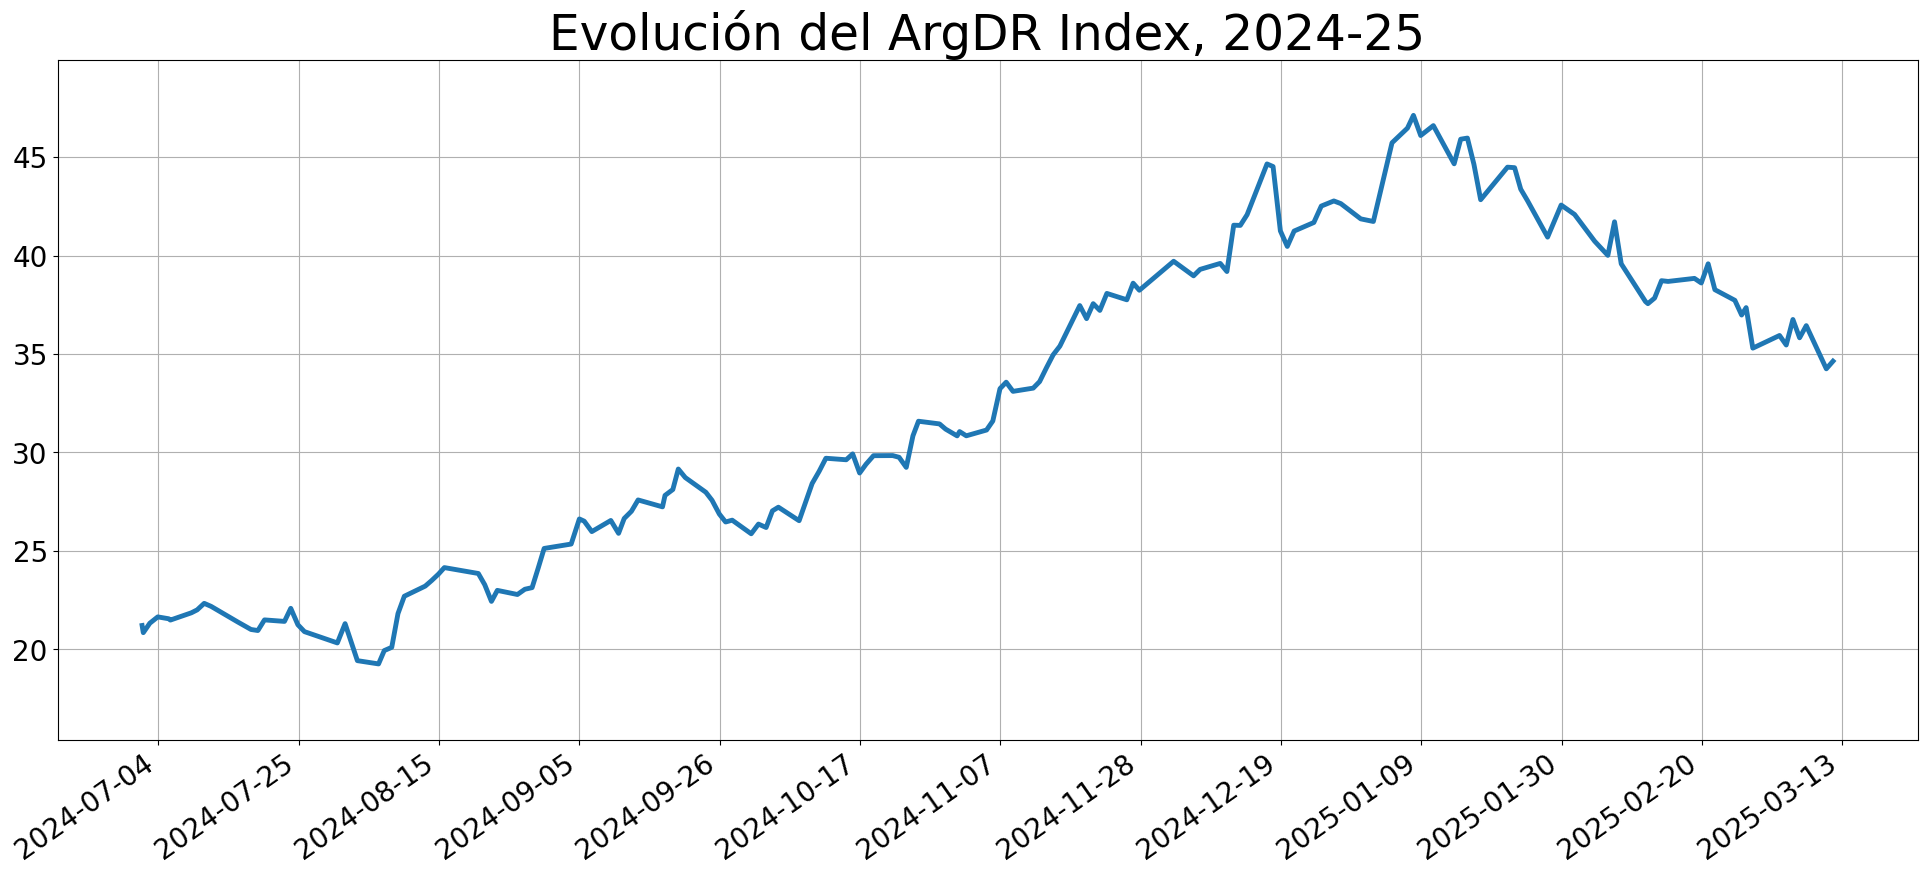

In [ ]:
plt.figure(figsize=(24,10))
plt.plot(filtered_df.index, filtered_df['Valor'], linewidth = 3.5)
plt.title('Evolución del ArgDR Index, 2024-25', fontsize=35)
plt.yticks(fontsize=20)

# Format x-axis with dates
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(21))  # Set ticks every 21 days
plt.gcf().autofmt_xdate()  # Auto-format date labels
plt.xticks(fontsize=20, rotation=35)

plt.grid()
plt.ylim(filtered_df['Valor'].min() * 0.8, filtered_df['Valor'].max() * 1.06)
# Save the plot as a .jpeg file
plt.savefig('Graph and chart outputs\ArgDR_chart.jpeg', format='jpeg')